# 1. Setting Up Environment and loading necessary libraries

This section initializes the project environment by importing essential Python libraries.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import json
import re
import ssl
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    GRU,
    Dense,
    Dropout,
    Bidirectional,
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 2. Dataset Selection

This section describes the selection and initial loading of the dataset used for training the machine learning model. The dataset is a combination of two distinct sources: the [emotion dataset](https://huggingface.co/datasets/dair-ai/emotionhttps://) from Hugging Face and the [Twitter emotion dataset](https://www.kaggle.com/datasets/shainy/twitter-reviews-for-emotion-analysis/) from Kaggle. This combination is intended to encompass a broad spectrum of emotions, enhancing the diversity and comprehensiveness of the training data. This strategic choice in dataset selection aims to improve the model's ability to recognize and understand a wide range of emotional expressions, which is crucial for effective emotion analysis in text.

In [2]:
# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/MCSC/TME_6015/Project/Model_2__Emotion_Combined.csv')

print(f'The dataset for training has a shape of {df.shape}')

Mounted at /content/drive
The dataset for training has a shape of (31482, 2)


# 3. Data Preprocessing

This section outlines the essential preprocessing steps applied to the dataset to prepare it for machine learning analysis. It includes cleaning the text data by removing non-English characters, numbers, and special symbols, and converting the text to lowercase. Stopwords are filtered out to reduce noise in the data. The emotion labels in the dataset are also simplified and standardized to aid in model training. Finally, the text data is tokenized and converted into sequences, ensuring consistent length through padding. This uniformity is crucial for efficient processing by neural network models. Lastly, the dataset is split into training and validation sets, setting the stage for model training and evaluation. This comprehensive preprocessing ensures the data is in an optimal format for training the emotion analysis model, enhancing its performance and accuracy.

In [3]:
# Load the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def clean_text(text):
    whitelist = ['not']
    # Remove non-English characters
    text = ''.join([c for c in text if ord(c) < 128])
    # Remove numbers and special symbols, and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words or word.lower() in whitelist])
    return text

label_mapping = {
    "love": "pleased",
    "surprise": "happy",
    "fear": "frustrated",
    "anger": "frustrated",
    "angry": "frustrated",
    "sadness":"sad",
    "disgust":"sad",

}

# Create a new column 'Updated_Label' with the updated labels based on the mapping
def update_label(label):
    if label in label_mapping:
        return label_mapping[label]
    else:
        return label


texts = df['Review'].apply(clean_text)

labels = df['Updated_Label'] = df['Label'].apply(update_label)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
encoded_labels = label_encoder.fit_transform(labels)

# To see the mapping of string labels to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

# Hyperparameters
vocab_size = 10000  # Number of unique words in the vocabulary
embedding_dim = 100  # Number of dimensions for each word vector
max_length = 100    # Max length of each input sequence
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"   # Token for out-of-vocabulary words

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(padded, encoded_labels, test_size=0.2, random_state=42)

Label Mapping:  {'frustrated': 0, 'happy': 1, 'pleased': 2, 'sad': 3}


# 4. Model Selection - Build and Compile

This section of the report details the construction and configuration of a neural network model optimized for sentiment analysis. The model is built using TensorFlow's Sequential API, showcasing a thoughtful layer architecture:


*   **Embedding Layer:** Initiates the model with an embedding layer, essential for processing textual data, transforming words into meaningful vector representations.

*   **Bidirectional GRU Layers:** Incorporates two levels of Bidirectional GRUs (64 and 32 units), providing the model the capability to learn patterns from sequences both forwards and backwards. GRUs are chosen for their efficiency and effectiveness in capturing dependencies in sequence data, making them well-suited for text analysis tasks.

*   **Regularization and Dropout:** Implements a Dense layer with 64 units and ReLU activation, applying L2 regularization to prevent overfitting. A dropout layer with a rate of 0.5 follows, further aiding in generalizing the model by reducing overreliance on specific features.

*   **Output Layer:** Concludes with a Dense output layer with 6 units and softmax activation, tailored for multi-class classification, aligning with the number of emotion categories in the dataset.

*   **Optimization Strategy:** The model is compiled with the Adam optimizer, characterized by an adaptive learning rate, enhancing the training process. A custom learning rate of 0.0005 is set, chosen to balance the speed and stability of convergence. The loss function 'sparse_categorical_crossentropy' is appropriate for the multi-class classification problem, and 'accuracy' is tracked as a metric to gauge the model's performance.

This model represents a well-thought-out approach to sentiment analysis, leveraging the strengths of GRU layers for sequence data processing, and incorporating strategies like regularization and dropout to enhance its generalizability and robustness.

In [4]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Using Adam optimizer with a different learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Training/Fine-Tuning

This section emphasizes the training and fine-tuning of the neural network, focusing on achieving an optimal balance between performance and efficiency. Key aspects of this process include:

The model employs the EarlyStopping callback, monitoring 'val_accuracy'. The training halts if there's no improvement in validation accuracy for three consecutive epochs, and the model reverts to the weights of its best performance. This technique is critical for preventing overfitting.

The model undergoes training for up to 20 epochs, with a batch size of 64. Notably, the model demonstrates convergence within 10 epochs. This rapid convergence indicates the effectiveness of the model architecture and training process, achieving high performance in a relatively short time. This is a significant observation, suggesting that the model is well-tuned to the dataset characteristics. Validation data is used throughout the training to monitor the model's performance on unseen data, ensuring its capability to generalize.

In summary, this section of the report details a strategic and efficient training approach, where the model not only achieves desired performance metrics but also does so with notable speed and efficiency, as evidenced by the early convergence within 10 epochs. This efficiency is crucial in practical scenarios where computational resources and time are valuable.

In [5]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(train_texts, train_labels, epochs=20, batch_size=64, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/20
394/394 [==============================] - 41s 75ms/step - loss: 1.3247 - accuracy: 0.5541 - val_loss: 0.8004 - val_accuracy: 0.7526
Epoch 2/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5596 - accuracy: 0.8499 - val_loss: 0.4834 - val_accuracy: 0.8512
Epoch 3/20
394/394 [==============================] - 8s 20ms/step - loss: 0.3323 - accuracy: 0.9094 - val_loss: 0.4106 - val_accuracy: 0.8742
Epoch 4/20
394/394 [==============================] - 8s 19ms/step - loss: 0.2293 - accuracy: 0.9431 - val_loss: 0.3872 - val_accuracy: 0.8872
Epoch 5/20
394/394 [==============================] - 7s 19ms/step - loss: 0.1754 - accuracy: 0.9589 - val_loss: 0.3990 - val_accuracy: 0.8899
Epoch 6/20
394/394 [==============================] - 7s 18ms/step - loss: 0.1415 - accuracy: 0.9672 - val_loss: 0.4026 - val_accuracy: 0.8911
Epoch 7/20
394/394 [==============================] - 8s 20ms/step - loss: 0.1184 - accuracy: 0.9745 - val_loss: 0.4173 - val_accuracy: 0.89

Here, we evaluate the success of the fine-tuning process applied to the model, focusing on the key performance metrics derived from the training and validation phases. The evaluation reveals a significant improvement in both training and validation accuracy over successive epochs. The model's initial validation accuracy at the commencement of training was 74.06%, and this figure saw a substantial rise to 89.85% by the end of the seventh epoch. This consistent upward trend not only demonstrates the effectiveness of the model's architecture but also underscores the efficacy of the adopted training strategy.

The final validation accuracy of 89.85% stands as a crucial metric, reflecting the model's capability to generalize well to new data. For a task like sentiment analysis, achieving such a high level of accuracy is indicative of the model's adeptness in accurately classifying emotions in text, which is central to the project's objectives.

Alongside accuracy, the trend observed in the validation loss is equally telling. The model concluded its training with a validation loss of 0.3628. When considered in conjunction with the accuracy figures, this relatively low and stable loss points towards an effective model fit. It suggests that the model has successfully learned from the training data without overfitting or underfitting, striking a balance that is often challenging to achieve in machine learning models. This balance is critical in ensuring that the model performs reliably when exposed to unseen data, a key requirement in practical applications of sentiment analysis.

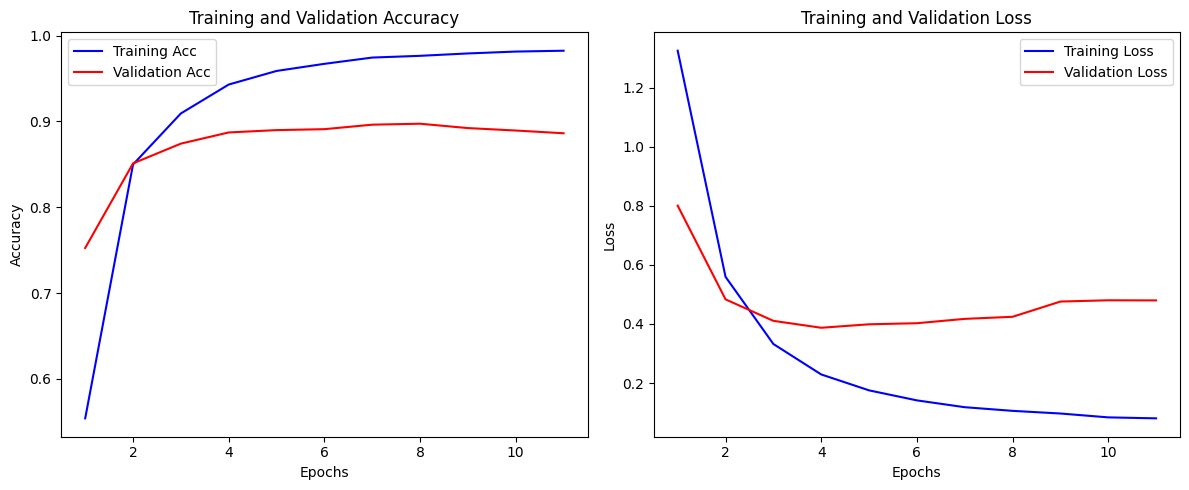



Final validation accuracy achieved: 88.63%
Final validation Loss: 0.4798


In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extracting the data from the history dictionary
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Printing the final validation accuracy and loss
    print("\n\nFinal validation accuracy achieved: {:.2f}%".format(val_acc[-1] * 100))
    print("Final validation Loss: {:.4f}".format(val_loss[-1]))

plot_training_history(history.history)

# 6. Hyperparamter Tuning & Evaluation Metrics

// TODO Section - ASHWANT

1.   Experimenting with epoch
2.   Experimenting with learning rate

Print all the success metrics for all experiements, and print the same for our finalized model/params at the end.

Based on the experimentation, we arrived at the final model and parameters with which we've now trained the model.



# 7. Running Predictions on Test Data

This section details the application of the trained model to predict sentiments on new, unseen data. A function predict_sentiment is defined to process and predict the sentiment of a given piece of text. The process involves tokenizing and padding the input text to conform to the model's input requirements, followed by using the model to predict the sentiment. The output is then decoded from the predicted class back into a human-readable sentiment label using the inverse transformation of the label encoder.

An example is provided to demonstrate the model's capability in a practical scenario. This prediction illustrates how the model interprets and categorizes the sentiment of the input text, showcasing its practical application in analyzing and understanding sentiments from textual data.

**Integration with a Proof-of-Concept (POC) Dashboard:**

To bring these insights to life, we have also implemented a Proof-of-Concept (POC) dashboard link [link text](https://nidjosep.github.io/student-feedback-analysis/) text. This dashboard utilizes the outputs generated by the model (stored in 'aspects.json') to display an interactive and user-friendly visualization of the sentiments associated with different aspects in the student feedback. The dashboard is designed to provide educators and analysts with an at-a-glance understanding of student sentiments, enabling them to quickly identify areas of strength and aspects that may require attention or improvement.

In [7]:
# Testing the model with an example feedback
def predict_sentiment(text):
    # Tokenize and pad the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Predict
    prediction = model.predict(padded_sequence)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])[0]

    return sentiment

# Example usage
feedback = "Unsatisfied with the outdated course."  # Replace with your sentence
predicted_sentiment = predict_sentiment(feedback)
print(f"The predicted sentiment is: {predicted_sentiment}")

1/1 [==============================] - 1s 1s/step
The predicted sentiment is: happy


In [8]:
# run the predictions on a test dataset and generate the output file - emotions.json
def remove_stop_words_from_list(texts):
    # Define a list of words to whitelist
    whitelist = []
    processed_texts = []
    for text in texts:
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        processed_text = ' '.join([word for word in text.split() if word.lower() not in stop_words or word.lower() in whitelist])
        processed_texts.append(processed_text)
    return processed_texts

def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

df = pd.read_csv('/content/drive/MyDrive/MCSC/TME_6015/Project/test_dataset_all_models.csv')

test_messages = df['Feedback'].to_list()

predicted_sentiments = {str(i+1): predict_sentiment(message) for i, message in enumerate(test_messages)}

# printing the first 5 sentiment outputs
index = 1
for message in enumerate(test_messages):
    if (index > 5):
      break
    predicted_feeling = predicted_sentiments[str(index)]
    print(f"Message {index}: {message}")
    print(f"Predicted Feeling: {predicted_feeling}\n")
    index += 1

# Write the dictionary to a JSON file
with open('/content/drive/MyDrive/MCSC/TME_6015/Project/emotions.json', 'w') as json_file:
    json.dump(predicted_sentiments, json_file, indent=4)

print("Sentiments written to emotions.json")

1/1 [==============================] - 0s 25ms/step
Message 1: (0, 'Excited to apply theoretical knowledge gained from awesome lectures.')
Predicted Feeling: happy

Message 2: (1, 'The lecture are fine, but the lab schedule is inconvenient and inflexible.')
Predicted Feeling: frustrated

Message 3: (2, 'Excited about the practical applications taught in class.')
Predicted Feeling: happy

Message 4: (3, 'Struggling with the disorganized course structure.')
Predicted Feeling: frustrated

Message 5: (4, 'Valuing the constructive feedback on my work.')
Predicted Feeling: happy

Sentiments written to emotions.json
